In [1]:
from modules import ssm
from modules import similarity as dist
import pandas as pd
import re
from functools import reduce

#open dataframes stored in hdf container
with pd.HDFStore('resources/mldb_watanabe_5plus_seg_english.hdf') as store:
    songs = store['mldb_watanabe_5plus_seg_english']
    
with pd.HDFStore('resources/ssm_store_pub1.hdf') as store:
    ssms_string = store['mdb_127_en_seg5p_string_1'].append(store['mdb_127_en_seg5p_string_2'])
    ssms_string.set_index(['id'], inplace=True)
    
with pd.HDFStore('resources/borders_pub1.hdf') as store:
    borders = store['mdb_127_en_seg5p']
    borders.set_index(['id'], inplace=True)

In [2]:
#check for normal (\n\n) and anomalous segment border indicators (e.g. \n\n\n\n, \n\n \n\n) and replace them with <segmentborder>
#afterwards: replace line border indicators (\n) with <lineborder>
#tree structure: encodes segment borders and line borders
def tree_structure(text):
    #normalize segment border encoding
    segment_border_encoder = '<segmentborder>'
    line_border_encoder = '<lineborder>'
    tree_string = re.sub('(( )*\n( )*){2,}', segment_border_encoder, text)
    tree_string = re.sub('( )*\n( )*', line_border_encoder, tree_string)
    #parse tree_string
    segment_structure = tree_string.split(segment_border_encoder)
    tree_structure = list(map(lambda segment: segment.split(line_border_encoder), segment_structure))
    return tree_structure

#removed fancy stuff like bracket removal here, until we have stable results
def normalize_lyric(lyric):
    return lyric.lower()

#given a text tree structure, print it nicely
def pretty_print_tree(text_tree):
    space_between = '    '
    res = ''
    output_separator = '\n'
    block_index = 0
    line_index = 0
    for block in text_tree:
        if not block:
            continue
        line_in_block_index = 0
        for line in block:
            line = line.strip()
            if not line:
                continue
            line_pretty = space_between + str(block_index) + '.' + str(line_in_block_index)\
                          + space_between + str(line_index) + space_between + line + output_separator
            res += line_pretty
            line_in_block_index += 1
            line_index += 1
        block_index += 1
        res += output_separator
    return space_between + res

segment borders: [10, 17, 28, 35, 42] 

        0.0    0    i'm taking it in
    0.1    1    i'm holding it back
    0.2    2    i'm filling my lungs with the knife in my back
    0.3    3    but you kept going on just to make me feel like this
    0.4    4    now that it's over
    0.5    5    i won't feel the same
    0.6    6    a broken frame with our picture is wasted
    0.7    7    i've thrown it away
    0.8    8    losing sight
    0.9    9    you were all i had (all i can take...)
    0.10    10    i guess the jokes on me

    1.0    11    we missed our chance
    1.1    12    i won't forget
    1.2    13    as time will only tell where to go
    1.3    14    (time will only tell where you go)
    1.4    15    though i wish that you weren't breathing
    1.5    16    i still just can't believe
    1.6    17    you're gone...

    2.0    18    and i was looking for something
    2.1    19    but i came up with nothing
    2.2    20    not a reason to leave or let this out
    

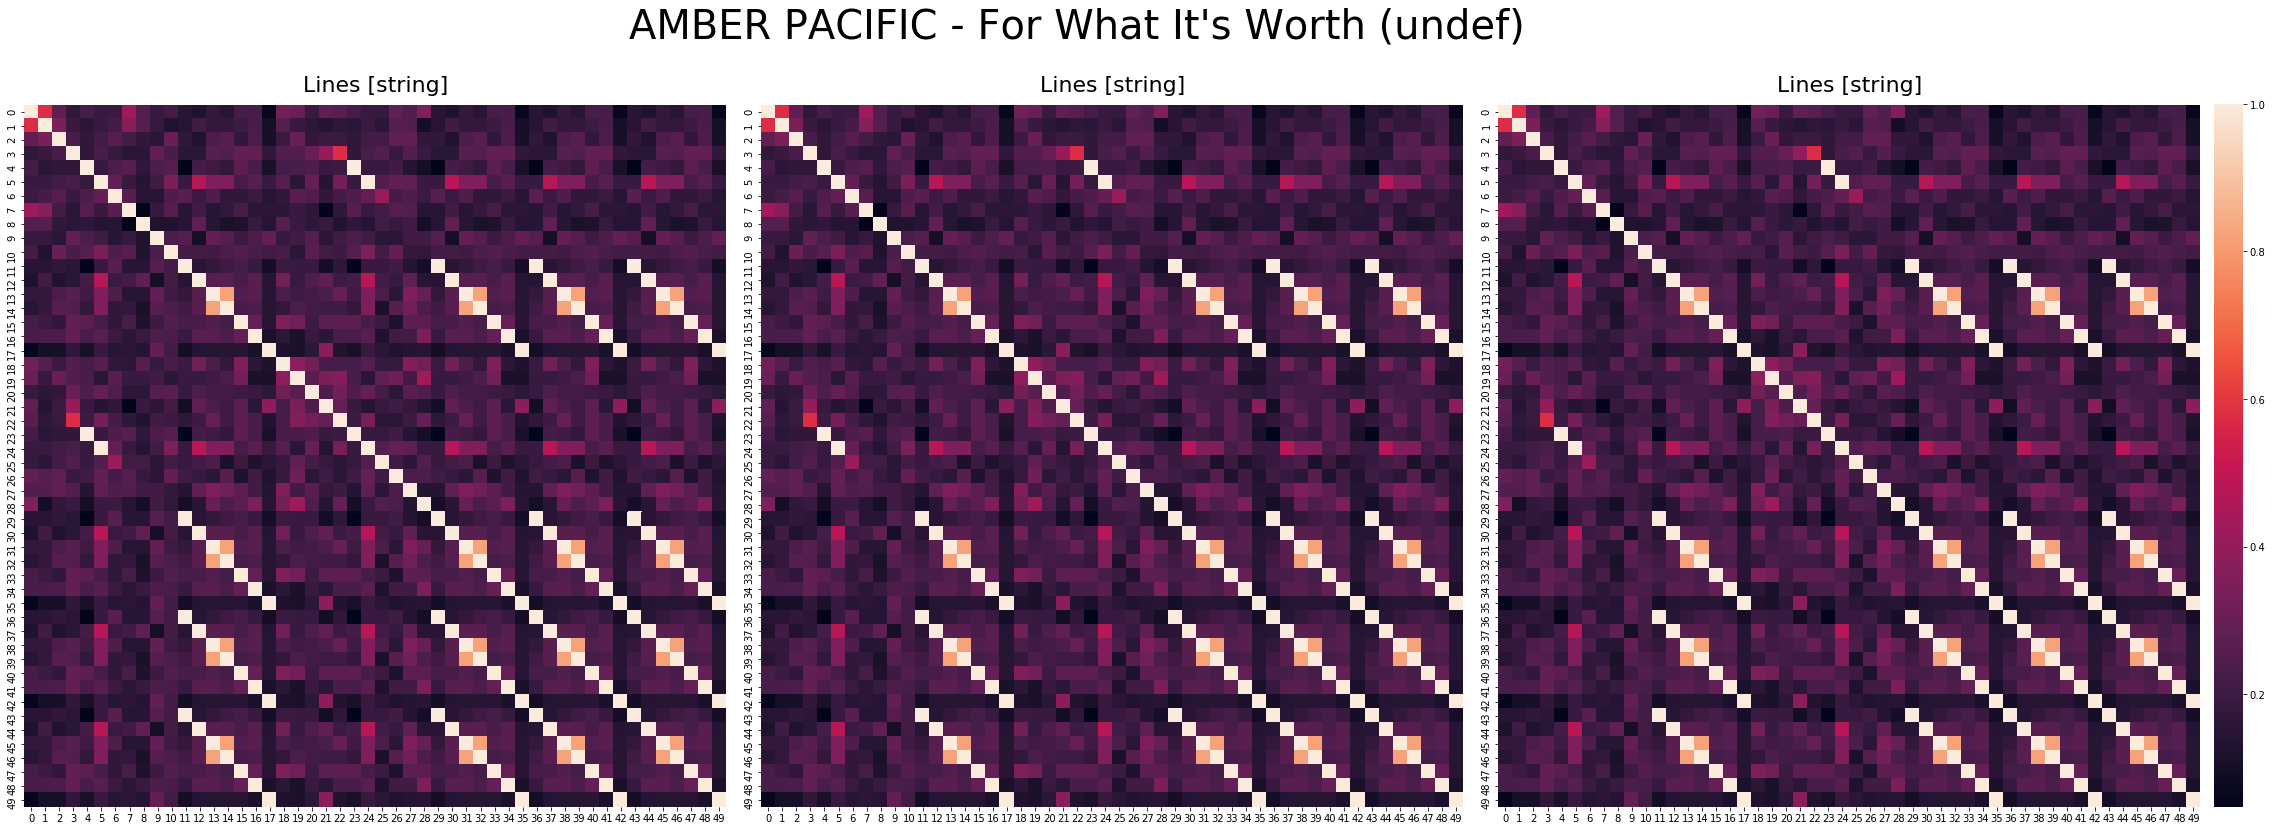

In [3]:
################################################
############---MULTIPLE ENCODINGS---############
################################################

#select some song here
song = songs.iloc[3829]

song_id = song.id
lyric = song.a_lyrics

#get borders and SSM from stores
segm_borders = borders.loc[song_id].borders
ssm_lines_string = ssms_string.loc[song_id].ssm

print('segment borders:', segm_borders, '\n')
print(pretty_print_tree(tree_structure(normalize_lyric(lyric))))

#can show different encoding here, for now it's the same everywhere
ssm.draw_ssm_encodings_side_by_side(ssm_some_encoding=ssm_lines_string, ssm_other_encoding=ssm_lines_string, ssm_third_encoding=ssm_lines_string,\
                                    representation_some = 'string', representation_other = 'string', representation_third = 'string',\
                                    artist_name=song.a_name, song_name=song.a_song, genre_of_song='undef')

In [4]:
#DEBUGGING: how the segment borders are computed

#The indices of lines that end a segment
def segment_borders(lyric):
    normalized_lyric = normalize_lyric(lyric)
    segment_lengths = reduce(lambda x, block: x + [len(block)], tree_structure(lyric), [])
    segment_indices = []
    running_sum = -1
    for i in range(len(segment_lengths)):
        running_sum += segment_lengths[i]
        segment_indices.append(running_sum)
    return segment_indices[:-1]

def segment_count(lyric):
    return 1 + len(segment_borders(lyric))

In [5]:
#DEBUGGING: how an SSM is computed

#flattened tree structure, does not differentiate between segment and line border
def line_structure(text):
    return reduce(lambda x, segment: x + segment, tree_structure(text), [])

lyric = song.a_lyrics
normalized_lyric = normalize_lyric(lyric)
line_encoding_string = line_structure(normalized_lyric)
ssm.self_similarity_matrix(line_encoding_string, metric=lambda x,y: pow(dist.string_similarity(x,y), 1))

array([[ 1.        ,  0.57894737,  0.2826087 , ...,  0.225     ,
         0.23076923,  0.0625    ],
       [ 0.57894737,  1.        ,  0.34782609, ...,  0.2       ,
         0.23076923,  0.10526316],
       [ 0.2826087 ,  0.34782609,  1.        , ...,  0.17391304,
         0.23913043,  0.10869565],
       ..., 
       [ 0.225     ,  0.2       ,  0.17391304, ...,  1.        ,
         0.3       ,  0.15      ],
       [ 0.23076923,  0.23076923,  0.23913043, ...,  0.3       ,
         1.        ,  0.11538462],
       [ 0.0625    ,  0.10526316,  0.10869565, ...,  0.15      ,
         0.11538462,  1.        ]])